In [2]:
using DataFrames
using Polynomials
using JuMP
using TimerOutputs
using Plots

In [222]:

#===Don't use this: Updated version is below
function findRange(r, R)
    bounds = Array{Float64}(undef, (0, 2))
#     bounds = [L+l L+l+r]
#     println("r = ", r, "R = ", R)
    if R != r
        bounds = [0 r; r R; R R+r]
    else
        bounds = [0 r; r r+R]
    end
#     if R > r
#         bounds = vcat(bounds,[L+l+r U+l])
#     end
#     bounds = vcat(bounds,[U+l U+u])
#     int_range = 
    return bounds
end
function timeShift(poly, direction, r)
    c = coeffs(poly)
    myRoot = 0
    if direction == "left"
        myRoot = -r
    end
    
    if direction == "right"
        myRoot = r
    end
    multiplier_poly = Polynomial([1]) #fromroots([4])*(-1)
    # println(multiplier_poly)
    my_poly = Polynomial([0])

    for i = 1:length(c)
        my_poly = my_poly + multiplier_poly*c[i]
        multiplier_poly = multiplier_poly*(fromroots([myRoot])) 
    end
    return my_poly
end

function Convolve()
    #Identify arcs having uncertain base costs:
#     cL = [5.7, 3.5, 2.3, 1.1]
#     cU = [20.8, 9.6, 6.4, 3.2]
#     cL = [5,2,1,3]
#     cU = [8,4,3,5]
    cL = [0,0,0]
    cU = [3,1,2]
    #Temporary Creating ranges here:
    df_Uniform = DataFrame(LB = Float64[], UB = Float64[], r = Float64[])
    unc_arcs = findall(cU.>cL)
    for i = 2:length(unc_arcs)
        k = unc_arcs[i]
        push!(df_Uniform,(cL[k],cU[k],cU[k]-cL[k]))
    end
    
    
    numOrder = length(cL)  #maxOrder = numOrder - 1 since we need to account for degree 0
    df = DataFrame(PolyNum = String[], Poly = Polynomial{Float64}[], l = Float64[], u = Float64[], leftShift = Float64[])
    push!(df,("", 1/(cU[1]-cL[1]), cL[1],cU[1], 0.0))
    numPoly = 1
    ii=0
#     println(df_Uniform)
#     println(df)
    while length(df_Uniform[:,:LB]) > 0
        l1 = df_Uniform[1,:LB]
        u1 = df_Uniform[1,:UB]
        r1 = df_Uniform[1,:r]
        
        poly1 = Polynomial([1/r1])
        #Timeshift here:
            if l1 > 0
                poly1 = timeShift(poly1, "left", l1)
            end
        l1LeftShift = l1
        u1 = u1 - l1
        l1 = 0
        poly_to_Integrate = length(df[:, :PolyNum])
        ii=ii+1
       
        println(df)
        println(df_Uniform)
        for k = 1:poly_to_Integrate #numPoly #numOrder-1
            
#             println("\n\n Adding a Uniform distribution to poly #", k)
            #Identify the intervals
            l2 = df[k,:l]
            u2 = df[k,:u]
            r2 = u2 - l2
            
            
            poly2 = df[k,:Poly]

            
            
            
            #Timeshift here:
            if l2 > 0
                poly2 = timeShift(poly2, "left", l2)
            end
            
            totalLeftShift = l1LeftShift + l2 + df[k,:leftShift]
            println("\nConvolving (",poly1,") and (", poly2,")")
#             println(df)
            u2 = u2 - l2
#             u1 = u1 - l1
            l2 = 0
#             l1 = 0
            
            bounds = []
            int_L = 0
            int_U = 0
#             println("r1 = ", r1)
#             println("r2 = ", r2)
            println("poly1 = ", poly1,"; ",l1, ", ", u1)
            println("poly2 = ", poly2,"; ",l2, ", ", u2)
            if r2 > r1
                bounds = findRange(r1, r2)
#                 int_L, int_U = l1, u1
                abs_L, abs_U = 0, r2
                root_L = r1
#                 println("r2 > r1: ", l2,", ", u2)
            else
                bounds = findRange(r2, r1)
#                 int_L, int_U = l2, u2
                abs_L, abs_U = 0, r1
                root_L = r2
#                 println("r2 < r1: ", l1,", ", u1)
            end
            println("Bounds = ", bounds)            
#             println("Integrate: (", poly1, ")(", poly2,")")
#             println("Given bounds (0, t), (t-",root_L, ", t), (t-",root_L,", ", abs_U,")")
            
            #This returns the function that we need to integrate wrt different sets of bounds
            p_combine = poly1 * poly2
#             println("p_combine = ", p_combine)
            
            
            #Integrate p_combine: Same for all 2 or 3 ranges below
            p_int = integrate(p_combine)
#             println("p_int = ", p_int)

            #Calculate the lower-bound polynomial with variable 
            #E.g. if the integration goes from t-4 to t then the lower bound is evaluated at t-4
            #E.g. if the integration goes from t-3 to t-1 then the upper bound is evaluated at t-1
            #Note that for the lower bound integral we use fromroots([int_U]) since t-int_U gives us a lower bound
            #Note that for the upper bound integral we use fromroots([int_L]) since t-int_L gives us an upper bound
            
            #Evaluate p_int at the lower bound t-root_L is
            #similar to perform time shift to the right or when = "post" 
            my_poly_L = timeShift(p_int, "right", root_L)
#             println("1")
            #===
            c = coeffs(p_int)
            multiplier_poly_L = Polynomial([1])
            my_poly_L = Polynomial([0])
#             println("root_L = ", root_L )
            for i = 1:length(c)
#                 println("\nComputing the middle polynomial at the lower bound")
#                 println("Order ", i-1, " coef = ",c[i])
#                 println("multiplier_poly_L : ", multiplier_poly_L)
                my_poly_L = my_poly_L + multiplier_poly_L*c[i]
                multiplier_poly_L = multiplier_poly_L*(fromroots([root_L])) 
            end
#             println("p_int evaluated at root_L", my_poly_L)
            ===#
            
            #Evaluate with 1st resulting range: from L to t
            println("\nRange 1:")
            println("Going from ", abs_L," to t")
            L = bounds[1,1]
            U = bounds[1,2]
            p_1 = p_int - p_int(abs_L) #Note that p_combine evaluated at t returns the same polynomial 
#             println("p_")
            println("p_1 before: ", p_1)
#             p_1 = timeShift(p_1, "right", l1+l2)
#             println("p_1 after: ", p_1)
            df[k,:] = df[k,:PolyNum]*".1", p_1, L, U, totalLeftShift         

            #Deal with 2nd resulting range: from t-some_range to t
            #If there are only 2 resulting ranges then we don't need to calculate this.
            row = 2
            if length(bounds[:,1]) > 2
                println("\nRange 2:")
                println("Going from (t-", root_L,") to t")
                numPoly = numPoly + 1
                p_2 = p_int - my_poly_L
                println("p_2 before: ", p_2)
#                 p_2 = timeShift(p_2, "right", l1+l2)
                push!(df,(df[k,:PolyNum]*"."*string(row), p_2, bounds[row,1], bounds[row,2],totalLeftShift))
                row = row + 1
            end
            
            println("\nRange 3:")
            println("Going from (t-", root_L,") to ", abs_U)
            p_3 = p_int(abs_U) - my_poly_L
            println("p_3 before: ", p_3)
#             p_3 = timeShift(p_3, "right", l1+l2)
            numPoly = numPoly + 1
            push!(df,(df[k,:PolyNum]*"."*string(row),p_3,bounds[row,1],bounds[row,2],totalLeftShift))

        end
        delete!(df_Uniform, 1)
    end
    println(df)
    p=0
    total = 0
    for i = 1:length(df[:,:PolyNum])
#         if df[i,:l]+df[i,:leftShift] <= VaR
            poly = df[i,:Poly]
#             leftShift = df[i,:leftShift]
#             u = df[i,:u]
#             l = df[i,:l]
        
#             poly = timeShift(poly, "left", leftShift)
#             df[i,:leftShift] =  leftShift + l
#             df[i,:u] = u-l
#             df[i,:l] = 0
            
            rightShift = df[i,:leftShift]
            poly = timeShift(poly, "right", rightShift)
            
            df[i,:Poly] = poly
        
            df[i,:u] = df[i,:u]+rightShift
            df[i,:l] = df[i,:l]+rightShift
            df[i,:leftShift] = 0
            u = df[i,:u]#+rightShift
            l = df[i,:l]#+rightShift
#             df[i,:u] = u
#             df[i,:l] = l
#             df[i,:leftShift] = 0
            p_poly = integrate(poly)
            p_temp = p_poly(u) - p_poly(l)
            p = p + p_temp
#             #Need to deal with this
            e_poly = integrate(poly*Polynomial([0,1]))
            total = total + (e_poly(u) - e_poly(l))#*p_temp
#         end
    end
    println(df)
    println("p = ", p)
    
#     p = 0
    println("\n\n\n")
    VaR = 20
    
    
#     #The original
#     for i = 1:length(df[:,:PolyNum])
#         if df[i,:l]+df[i,:leftShift] <= VaR
#             poly = df[i,:Poly]
#             rightShift = df[i,:leftShift]
#             poly = timeShift(poly, "right", rightShift)
#             p_poly = integrate(poly)
#             u = min(VaR, df[i,:u]+rightShift)
#             l = df[i,:l]+rightShift
#             p_temp = p_poly(u) - p_poly(l)
#             p = p + p_temp
#             #Need to deal with this
#             e_poly = integrate(poly*Polynomial([0,1]))
#             total = total + (e_poly(u) - e_poly(l))#*p_temp
#         end
#     end
    println("β-VaR = ", VaR)
    println("β-CVaR = ", total/p)
    println("p = ", p)
     for i = 1:length(df[:,:PolyNum])
#         poly = df[i,:Poly]
#         rightShift = df[i,:leftShift]
#         poly = timeShift(poly, "right", rightShift)
        u = df[i,:u]#+rightShift
        l = df[i,:l]#+rightShift
#         df[i,:Poly] = poly
        
        df[i,:u] = round(u, digits=5)
        df[i,:l] = round(l, digits=5)
        
#         println("\na",i,"(x) = ", poly)
#         println("plot!(a",i,",",round(l, digits=5),",",round(u, digits=5),")")
    end
    
#     println("1")
#     cL = [5.7,3.5,2.3,1.1]
#     A = [5.7,3.5,2.3,1.1]
#     println(sum(A[i] for i = 1:3))
#     println("cL = ", sum(cL[i] for  i = 1:3))
    
#     println("a = ", a)
#     a = sum(cL[k] for k=1:length(cL))
#     df_plot = DataFrame(Poly = Polynomial{Float64}[], l = Float64[], u = Float64[])
    b = sum(cU[k] for k=1:length(cU))
    rangePlot = df[:,:l]
    rangePlot = unique(rangePlot)
#     df_plot[:,:l] = rangePlot
    push!(rangePlot, b)
    sort!(rangePlot)
#     df_plot[:,:l] = rangePlot[2:length(rangePlot)-1]
    println("length rangePlot = ", length(rangePlot)-1)
    poly4Plot = Polynomial{Float64}[]
    for i = 1:length(rangePlot)-1
        push!(poly4Plot, Polynomial([0]))
    end
#     println(poly4Plot)
    for j = 1:length(df[:, :PolyNum])
        poly = df[j,:Poly]
        println(j, ". Poly ", poly, "(",df[j,:l], ",", df[j,:u],")")
#         println()
        for i = 1:length(rangePlot)-1
            l = df[j, :l]
            u = df[j, :u]
            if l <= rangePlot[i] && u >= rangePlot[i+1]
#                 println("add to range ", rangePlot[i], ",", rangePlot[i+1])
                poly4Plot[i] = poly4Plot[i] + poly
            end
#             if u >= rangePlot[i] 
#                 poly4Plot[i] = poly4Plot[i] + poly
#             end
            
        end
    end
    for i = 1:length(rangePlot)-1
       println("r = (", rangePlot[i],",",rangePlot[i+1],") : ", poly4Plot[i]) 
    end
    return rangePlot, poly4Plot
end

start = time()
# for iter = 1:1 #50000
    rangePlot, poly4Plot = Convolve()
# end
println(rangePlot)
# println(poly4Plot)

# println("Run time = ", time()-start)

EndofDoNotUse========###

1×5 DataFrame
 Row │ PolyNum  Poly       l        u        leftShift 
     │ String   Polynomi…  Float64  Float64  Float64   
─────┼─────────────────────────────────────────────────
   1 │          0.333333       0.0      3.0        0.0
2×3 DataFrame
 Row │ LB       UB       r       
     │ Float64  Float64  Float64 
─────┼───────────────────────────
   1 │     0.0      1.0      1.0
   2 │     0.0      2.0      2.0

Convolving (1.0) and (0.333333)
poly1 = 1.0; 0, 1.0
poly2 = 0.333333; 0, 3.0
Bounds = [0.0 1.0; 1.0 3.0; 3.0 4.0]

Range 1:
Going from 0 to t
p_1 before: 0.333333*x

Range 2:
Going from (t-1.0) to t
p_2 before: 0.333333

Range 3:
Going from (t-1.0) to 3.0
p_3 before: 1.33333 - 0.333333*x
3×5 DataFrame
 Row │ PolyNum  Poly                  l        u        leftShift 
     │ String   Polynomi…             Float64  Float64  Float64   
─────┼────────────────────────────────────────────────────────────
   1 │ .1       0.333333*x                0.0      1.0        0.0
   2 │ .1.

In [120]:
#DUMMY TESTTTTTT########################
#ALWAYS FLIP THE UNIFORM PDF


# function findRange(r, R)
function findRange((l1,u1),(l2,u2))
    r = u1-l1
    R = u2-l2
    bounds = Array{Float64}(undef, (0, 2))
#     bounds = [L+l L+l+r]
#     println("r = ", r, "R = ", R)
    if R != r
        bounds = [0 r; r R; R R+r]
#         bounds =[ ]
        bounds = bounds.+(l1+l2)
    else
        bounds = [0 r; r r+R]
        bounds = bounds.+(l1+l2)
    end
#     if R > r
#         bounds = vcat(bounds,[L+l+r U+l])
#     end
#     bounds = vcat(bounds,[U+l U+u])
#     int_range = 
    return bounds
end
function timeShift(poly, direction, r)
    c = coeffs(poly)
    myRoot = 0
    if direction == "left"
        myRoot = -r
    end
    
    if direction == "right"
        myRoot = r
    end
    multiplier_poly = Polynomial([1]) #fromroots([4])*(-1)
    # println(multiplier_poly)
    my_poly = Polynomial([0])

    for i = 1:length(c)
        my_poly = my_poly + multiplier_poly*c[i]
        multiplier_poly = multiplier_poly*(fromroots([myRoot])) 
    end
    return my_poly
end

function Convolve()
    #Identify arcs having uncertain base costs:
#     cL = [5.7, 3.5, 2.3, 1.1]
#     cU = [20.8, 9.6, 6.4, 3.2]
#     cL = [8.17, 6.16, 2.66, 5.71, 9.85, 5.33, 8.15, 3.02, 8.83, 8.69]
#     cU = [8.83, 11.34, 11.61, 14.34, 12.94, 11.75, 10.77, 6.18, 15.99, 10.29]
    cL = [0.2, 9.58, 0.18, 1.24, 7.95, 8.81]
    cU = [6.99, 12.21, 7.64, 3.94, 11.04, 14.87]
#     cL = [5,2,1,3]
#     cU = [8,4,3,5]
#     cL = [0,0,0]
#     cU = [3,1,2]
    
#     cL = cL.+1
#     cU = cU.+1
    #Temporary Creating ranges here:
    df_Uniform = DataFrame(LB = Float64[], UB = Float64[], r = Float64[])
    unc_arcs = findall(cU.>cL)
    for i = 2:length(unc_arcs)
        k = unc_arcs[i]
        push!(df_Uniform,(cL[k],cU[k],cU[k]-cL[k]))
    end
    
    
    numOrder = length(cL)  #maxOrder = numOrder - 1 since we need to account for degree 0
    df = DataFrame(PolyNum = String[], Poly = Polynomial{Float64}[], l = Float64[], u = Float64[], leftShift = Float64[])
    push!(df,("", 1/(cU[1]-cL[1]), cL[1],cU[1], 0.0))
    numPoly = 1
    ii=0
    
    while length(df_Uniform[:,:LB]) > 0
        l1 = df_Uniform[1,:LB]
        u1 = df_Uniform[1,:UB]
        r1 = df_Uniform[1,:r]
        
        poly1 = Polynomial([1/r1])
        
        #Time shift Uniform Var.###
        l1LeftShift = l1
        ####Update (l1,u1)
        u1 = r1
        l1 = 0
        
        poly_to_Integrate = length(df[:, :PolyNum])
        ii=ii+1
       
#         println(df)
#         println(df_Uniform)
        for k = 1:poly_to_Integrate #numPoly #numOrder-1
            
#             println("\n\n Adding a Uniform distribution to poly #", k)
            #Identify the intervals
            l2 = df[k,:l]
            u2 = df[k,:u]
            r2 = u2 - l2
            
            poly2 = df[k,:Poly]
            
            #Shift poly2:
            poly2 = timeShift(poly2, "left", l2)
            #Update totalLeftShift
            totalLeftShift = l1LeftShift + l2 + df[k,:leftShift]
            #Update (l2,u2)
            
#             println("l1LeftShift = ", l1LeftShift)
#             println("l2 before reset = ", l2)
#             println("totalLeftShift = ", totalLeftShift)
            u2 = r2
            l2 = 0
#             println("\nConvolving (",poly1,") and (", poly2,")")
            
            bounds = []
            int_L = 0
            int_U = 0

#             println("poly1 = ", poly1,"; ",l1, ", ", u1)
#             println("poly2 = ", poly2,"; ",l2, ", ", u2)
            
            abs_L = l2
            abs_U = u2
            
            if r2 > r1
                bounds = findRange((l1,u1), (l2,u2))
#                 bounds = bounds.-l1
            else
                bounds = findRange((l2,u2), (l1,u1))
#                 bounds = bounds.-l1
            end
#             println("Bounds = ", bounds)            
#             println("Integrate: (", poly1, ")(", poly2,")")
#             println("Given bounds (0, t), (t-",root_L, ", t), (t-",root_L,", ", abs_U,")")
            
            #This returns the function that we need to integrate wrt different sets of bounds
            p_combine = poly1 * poly2
#             println("p_combine = ", p_combine)
            
            
            #Integrate p_combine: Same for all 2 or 3 ranges below
            p_int = integrate(p_combine)
#             println("p_int = ", p_int)

            #Calculate the lower-bound polynomial with variable 
            #E.g. if the integration goes from t-4 to t then the lower bound is evaluated at t-4
            #E.g. if the integration goes from t-3 to t-1 then the upper bound is evaluated at t-1
            #Note that for the lower bound integral we use fromroots([int_U]) since t-int_U gives us a lower bound
            #Note that for the upper bound integral we use fromroots([int_L]) since t-int_L gives us an upper bound
            
            #Evaluate p_int at the lower bound t-root_L is
            #similar to perform time shift to the right or when = "post" 
            
            my_poly_L = timeShift(p_int, "right", r1)
            
            
#             totalLeftShift = l1 + df[k,:leftShift]
#             println("1")
            #===
            c = coeffs(p_int)
            multiplier_poly_L = Polynomial([1])
            my_poly_L = Polynomial([0])
#             println("root_L = ", root_L )
            for i = 1:length(c)
#                 println("\nComputing the middle polynomial at the lower bound")
#                 println("Order ", i-1, " coef = ",c[i])
#                 println("multiplier_poly_L : ", multiplier_poly_L)
                my_poly_L = my_poly_L + multiplier_poly_L*c[i]
                multiplier_poly_L = multiplier_poly_L*(fromroots([root_L])) 
            end
#             println("p_int evaluated at root_L", my_poly_L)
            ===#
            
            #Evaluate with 1st resulting range: from L to t
#             println("\nRange 1:")
#             println("Going from ",l2," to t")
            L = bounds[1,1]
            U = bounds[1,2]
            p_1 = p_int - p_int(l2) #Note that p_combine evaluated at t returns the same polynomial 
#             p_1 = timeShift(p_1, "left", l1)
#             println("p_1 before: ", p_1)
            df[k,:] = df[k,:PolyNum]*".1", p_1, L, U, totalLeftShift         

            #Deal with 2nd resulting range: from t-some_range to t
            #If there are only 2 resulting ranges then we don't need to calculate this.
            row = 2
            if length(bounds[:,1]) > 2
#                 println("\nRange 2:")
                
                numPoly = numPoly + 1
                p_2 = Polynomial([0])
                if r2 > r1
#                     println("Going from (t-", r1,") to t")
                    p_2 = p_int - my_poly_L
                end
            
                if r2 < r1
#                     println("Going from ", l2," to ", u2)
                    interval_2 = p_int(u2) - p_int(l2)
                    p_2 = Polynomial([interval_2])
                end
#                 println("testing p_2 = ", p_2)
#                 p_2 = timeShift(p_2, "right", l1)
#                 println("p_2 before: ", p_2)
                push!(df,(df[k,:PolyNum]*"."*string(row), p_2, bounds[row,1], bounds[row,2],totalLeftShift))
                row = row + 1
            end
            
#             println("\nRange 3:")
#             println("Going from (t-", r1,") to ", u2)
            p_3 = p_int(u2) - my_poly_L
#             p_3 = timeShift(p_3, "left", l1)
#             println("p_3 before: ", p_3)
            numPoly = numPoly + 1
            push!(df,(df[k,:PolyNum]*"."*string(row),p_3,bounds[row,1],bounds[row,2],totalLeftShift))

        end
        delete!(df_Uniform, 1)
    end
#     println(df)
    p=0
    total = 0
    println("\n\n\n")
    VaR = 30
    
    
    #The original
    for i = 1:length(df[:,:PolyNum])
        if df[i,:l]+df[i,:leftShift] <= VaR
            poly = df[i,:Poly]
            rightShift = df[i,:leftShift]
            poly = timeShift(poly, "right", rightShift)
            df[i,:Poly] = poly
            p_poly = integrate(poly)
            df[i,:u] = df[i,:u]+rightShift
            df[i,:l] = df[i,:l]+rightShift
            df[i,:leftShift] = 0
            u = min(VaR, df[i,:u]) #+rightShift)
            l = df[i,:l]#+rightShift
#             df[i,:u] = u
#             df[i,:l] = l
            
#             u = min(VaR, df[i,:u])
#             l = df[i,:l]
            p_temp = p_poly(u) - p_poly(l)
            p = p + p_temp
            #Need to deal with this
            e_poly = integrate(poly*Polynomial([0,1]))
            e_poly_val = e_poly(u) - e_poly(l)
            total = total + e_poly_val#*p_temp
            if p_temp <= 0
                println(i,". int()/p_cond = ", e_poly_val/p_temp, "; p_cond = ", p_temp)
            end
        end
    end
    
    println("β-VaR = ", VaR)
    println("β-CVaR = ", total/p)
    println("p = ", p)
    
    
    
    
    #Shifting just for plot
    for i = 1:length(df[:,:PolyNum])
#         if df[i,:l]+df[i,:leftShift] <= VaR
            poly = df[i,:Poly]
            rightShift = df[i,:leftShift]
            poly = timeShift(poly, "right", rightShift)
            df[i,:Poly] = poly
        
            p_poly = integrate(poly)
            u = df[i,:u]+rightShift
            l = df[i,:l]+rightShift
            df[i,:leftShift] = 0
            u = round(u, digits=5)
            l = round(l, digits=5)
            df[i,:u] = u
            df[i,:l] = l
            
#             u = min(VaR, df[i,:u])
#             l = df[i,:l]
#             p_temp = p_poly(u) - p_poly(l)
#             p = p + p_temp
#             #Need to deal with this
#             e_poly = integrate(poly*Polynomial([0,1]))
#             e_poly_val = e_poly(u) - e_poly(l)
#             total = total + e_poly_val#*p_temp
            
#             println(i,". int()/p_cond = ", e_poly_val/p_temp, "; p_cond = ", p_temp)
#         end
    end
#     for i = 1:length(df[:,:PolyNum])
#         u = df[i,:u]#+rightShift
#         l = df[i,:l]#+rightShift
        
        
# #         println("\na",i,"(x) = ", poly)
# #         println("plot!(a",i,",",round(l, digits=5),",",round(u, digits=5),")")
#     end
#     println(df)
    b = sum(cU[k] for k=1:length(cU))
    rangePlot = df[:,:l]
    rangePlot = unique(rangePlot)
#     df_plot[:,:l] = rangePlot
    push!(rangePlot, b)
    sort!(rangePlot)
#     df_plot[:,:l] = rangePlot[2:length(rangePlot)-1]
#     println("length rangePlot = ", length(rangePlot)-1)
    poly4Plot = Polynomial{Float64}[]
    for i = 1:length(rangePlot)-1
        push!(poly4Plot, Polynomial([0]))
    end
#     println(poly4Plot)
    for j = 1:length(df[:, :PolyNum])
        poly = df[j,:Poly]
#         println(j, ". Poly ", poly, "(",df[j,:l], ",", df[j,:u],")")
#         println()
        for i = 1:length(rangePlot)-1
            l = df[j, :l]
            u = df[j, :u]
            if l <= rangePlot[i] && u >= rangePlot[i+1]
#                 println("add to range ", rangePlot[i], ",", rangePlot[i+1])
                poly4Plot[i] = poly4Plot[i] + poly
            end
#             if u >= rangePlot[i] 
#                 poly4Plot[i] = poly4Plot[i] + poly
#             end
            
        end
    end
    for i = 1:length(rangePlot)-1
#        println("r = (", rangePlot[i],",",rangePlot[i+1],") : ", poly4Plot[i]) 
    end
    return rangePlot, poly4Plot
end

start = time()
# for iter = 1:1 #50000
    rangePlot, poly4Plot = Convolve()
# end
# println(rangePlot)
# println(poly4Plot)

# println("Run time = ", time()-start)





β-VaR = 30
β-CVaR = 29.70857104473572
p = 1.4862411731542124e-5


([27.96, 30.59, 30.66, 31.05, 33.29, 33.68, 33.75, 34.02, 34.75, 35.42  …  49.23, 49.9, 50.63, 50.9, 50.97, 51.36, 53.6, 53.99, 54.06, 56.69], Polynomial{Float64}[Polynomial(-21.142 + 3.78075*x - 0.27044*x^2 + 0.00967239*x^3 - 0.000172968*x^4 + 1.23726e-6*x^5), Polynomial(11.9984 - 1.63611*x + 0.0837187*x^2 - 0.00190521*x^3 + 1.62699e-5*x^4), Polynomial(45.5196 - 7.10272*x + 0.440314*x^2 - 0.0135359*x^3 + 0.000205941*x^4 - 1.23726e-6*x^5), Polynomial(81.2278 - 12.8528*x + 0.810692*x^2 - 0.0254643*x^3 + 0.000398025*x^4 - 2.47451e-6*x^5), Polynomial(30.642 - 5.25508*x + 0.354233*x^2 - 0.0117527*x^3 + 0.000192084*x^4 - 1.23726e-6*x^5), Polynomial(-22.9771 + 2.70501*x - 0.118456*x^2 + 0.00228202*x^3 - 1.62699e-5*x^4), Polynomial(-77.1558 + 10.7315*x - 0.594099*x^2 + 0.0163751*x^3 - 0.000225057*x^4 + 1.23726e-6*x^5), Polynomial(-20.775 + 2.44506*x - 0.106949*x^2 + 0.00205563*x^3 - 1.45996e-5*x^4), Polynomial(41.9201 - 6.57581*x + 0.412238*x^2 - 0.012885*x^3 + 0.000200374*x^4 - 1.23726e-6*x^

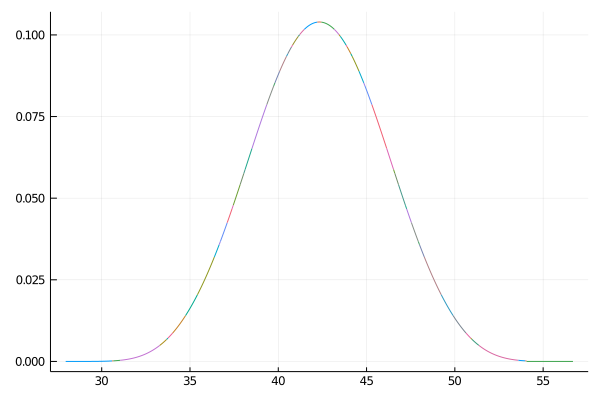

In [121]:
figure = plot(poly4Plot[1],rangePlot[1],rangePlot[2], leg=false)
for i = 2:length(rangePlot)-1
   figure = plot!(poly4Plot[i],rangePlot[i],rangePlot[i+1]) 
end
display(figure)

# pl1 = Polynomial([0,1/3]) #0.333333*x #0,1
# # println(pl1)
# pl2 = Polynomial([1/3]) #0.333333 #1,3
# pl3 = Polynomial([4/3,-1/3]) #1.33333 - 0.333333*x #3,4

# figure = plot(pl1,0,1,leg=false)
# figure = plot!(pl2,1,3)
# figure = plot!(pl3,3,4)

# s1 = integrate(pl1)(1)-integrate(pl1)(0)
# s2 = integrate(pl2)(3)-integrate(pl2)(1)
# s3 = integrate(pl3)(4)-integrate(pl3)(3)

# println(s1+s2+s3)

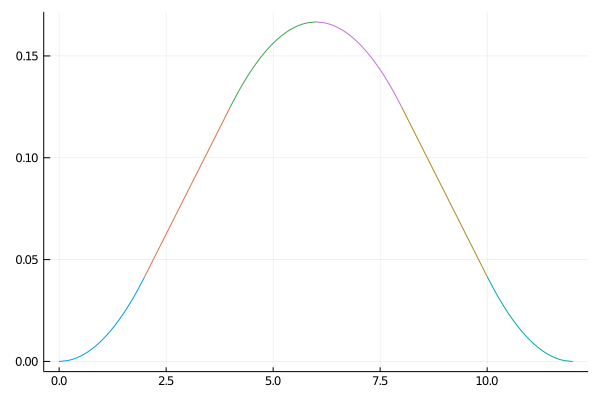

In [267]:
# poly = Polynomial{Float64}[]
poly1(t) = t^2/96 #0,2 #t^2/12 #0,1
poly2(t) = 1/24 + t/24 -1/12#2,4 #t/6 - 1/12 +((t-1)/6)  #1,2
poly3(t) = (-t^2/96+t/12-1/8) +t/24 -1/12#4,6 #-t^2/12+t/6+1/4 +((t-1)/6) #2,3
# poly4(t) = ((t-1)/6) #1,3
# poly5(t) = (-(t-1)/6 + 2/3) #3,5
poly6(t) = (-t^2/96+t/6-5/8) + (-t/24+10/24) #6,8 #(-(t-3)^2/12+(t-3)/6) +(-(t-1)/6 + 2/3)#3,4
poly7(t) = 1/24+(-t/24+10/24) #8,10 #(-(t-3)/6 + 1/4)+(-(t-1)/6 + 2/3) #4,5
poly8(t) = t^2/96 - t/4 + 3/2#(t-3)^2/12 -(t-3)/3 + 1/4 #5,6


figure = plot(poly1,0,2, leg=false)
# for i = 2:length(rangePlot)-1
figure = plot!(poly2,2,4) 
figure = plot!(poly3,4,6) 
figure = plot!(poly6,6,8) 
figure = plot!(poly7,8,10) 
figure = plot!(poly8,10,12) 
# figure = plot!(poly2,1,2) 
# end
display(figure)

In [122]:
K = []
N = 1000000#0#0
count = 0
cond_avg = 0
avg = 0
VaR = 30


#     cL = [5,2,1,3]
#     cU = [8,4,3,5]
# cL = [0,0,0,0]
# cU = [3,2,2,2]
# cL = [5,2,1,3]
# cU = [8,4,3,5]
# cL = [5.7, 3.5, 2.3, 1.1]
#     cU = [20.8, 9.6, 6.4, 3.2]
cL = [0.2, 9.58, 0.18, 1.24, 7.95, 8.81]
cU = [6.99, 12.21, 7.64, 3.94, 11.04, 14.87]
M = cU-cL
numRand = length(cL)
# M = [2,4,2,5.0]
# L = [1,1,1,1]
# U = [2,2,2,2]
c = zeros(numRand)
for i = 1:N
#     for j = 1:numRand
#         c[j] = rand()*(U[j]-L[j])+L[j]#rand()*2+1
#     end
    s = sum(rand()*M[j]+cL[j] for j = 1:length(cL))
#     c1 = rand()*M[1]+cL[1]
#     c2 = rand()*M[2]+cL[2]
#     c3 = rand()*M[3]+cL[3]
#     c4 = rand()*M[4]+cL[4]
#     c5 = rand()*M[5]+cL[5]
    
#     s = c1 + c2 + c3 #+ c4 #+ c5
#     println("s = ",s)
    if s <= VaR
#     if s>=7 && s<=9
        cond_avg = (cond_avg+s)
        count = count + 1
    end
    avg = (avg+s)
#     push!(K, s)
end
println("Cond. avg = ", cond_avg/count)
println("p = ", count/N)

println("Avg = ", avg/N)
# sort!(K)
# i = 0
# s = 0
# while K[i+1]<=5.4
#     i = i+1
#     s = s+ K[i]
# end
# println("CVaR ", s/i)


Cond. avg = 29.743311051546947
p = 1.7e-5
Avg = 42.32387175988242


In [ ]:
sum = 0
p = 0
for i = 1:length(df[:,:PolyNum])
    if df[i,:l] <= 5.4
        poly = df[i,:Poly]
        u = min(5.4, df[i,:u])
        l = df[i,:l]
        p = p + poly(u) - poly(l)
        int_poly = integrate(poly)
        sum = sum + poly(u) - poly(l)
    end
end
println(sum/p)

In [ ]:
# using DataFrames
df_test = DataFrame(a = Float64[], b = Float64[], c = Float64[])

push!(df_test, (0.5,0.2,0.1))
push!(df_test, (0.8,0.2,0.3))

A = df_test[1,1:3]
println(A)

In [ ]:
using Pkg 
Pkg.add("Polynomials")

In [ ]:
using Polynomials
poly = fromroots([2,2])
poly1 = Polynomial([0,1.5],:x)
poly = poly*poly1

typeof(poly)

In [ ]:
as = [1,2,3,4,5]
t = Polynomial(as)

In [ ]:
for i = 1:length(t)
    a = collect(t)[i](1)
    println(a, " ", typeof(a))
end

In [ ]:
ones(a)

In [ ]:
pp = Polynomial([1,1,2])
c = coeffs(pp)
multiplier_poly = Polynomial([1]) #fromroots([4])*(-1)
# println(multiplier_poly)
my_poly = Polynomial([0])
for i = 1:length(c)
    println("\nOrder ", i-1, " coef = ",c[i])
    println("Multiply with ", multiplier_poly)
    my_poly = my_poly + multiplier_poly*c[i]
    println("Resulting poly = ", my_poly)
    multiplier_poly = multiplier_poly*(fromroots([4])) 
end
println(my_poly)

In [ ]:
# fromroots([4])

In [17]:
A = [1 2 3]
A = insert(A, 2,10)

UndefVarError: UndefVarError: insert not defined

In [118]:
cL = rand(1:1000,6)
cU = cL + rand(1:1000,6)
cL = cL./100
cU = cU./100
println("cL = ", cL)
println("cU = ", cU)
println(sum(cL[i] for i = 1:6))
println(sum(cU[i] for i = 1:6))

cL = [0.2, 9.58, 0.18, 1.24, 7.95, 8.81]
cU = [6.99, 12.21, 7.64, 3.94, 11.04, 14.87]
27.96
56.690000000000005
